In [222]:
import pandas as pd
import matplotlib as plt
import plotly.graph_objs as go
import plotly.express as px
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('SMSSpamCollection.csv', sep = '\t', header = None, names=["cat","sms"])
df.head()

,cat,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [37]:
X = df['sms']
y = df['cat']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = 42, stratify = y)
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
X_train_CV = vectorizer.transform(X_train)
X_test_CV = vectorizer.transform(X_test)

X_test_CV

<1393x7387 sparse matrix of type '<class 'numpy.float64'>'
	with 17196 stored elements in Compressed Sparse Row format>

In [31]:
pickle.dump(vectorizer, open('tfidfvecto_mlp.pkl', 'wb'))

In [4]:
print(vectorizer.transform(['hello how are U']))
test_mot=vectorizer.transform(['send me dollars !!!'])

  (0, 3400)	0.5084539784949453
  (0, 3283)	0.7322658015323793
  (0, 1022)	0.45305777518855556


In [22]:
# LR

model = LogisticRegression(max_iter=150).fit(X_train_CV, y_train)
print(model.score(X_train_CV, y_train))
print(model.score(X_test_CV, y_test))

0.9808566642737497
0.9770279971284996


In [38]:
# Perceptron

ppn = Perceptron(random_state=0)
ppn.fit(X_train_CV, y_train)
y_pred = ppn.predict(X_test_CV)
print('Perceptron accuracy: %.5f' % accuracy_score(y_test, y_pred))


Perceptron accuracy: 0.98564


In [51]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train_CV.toarray(), y_train)
y_pred = nb.predict(X_test_CV.toarray())
print('Naive Bayes accuracy: %.5f' % accuracy_score(y_test, y_pred))

Naive Bayes accuracy: 0.88586


In [55]:
pickle.dump(nb, open('nb.pkl', 'wb'))

In [59]:
test_mot=vectorizer.transform(['i miss you']).toarray()
nb.predict(test_mot)[0]

'spam'

In [43]:
mlp = MLPClassifier(random_state=0)
mlp.fit(X_train_CV, y_train)
y_pred = mlp.predict(X_test_CV)
print('MLP accuracy: %.5f' % accuracy_score(y_test, y_pred))

MLP accuracy: 0.98708


In [60]:
mlp.predict(X_test_CV)

array(['ham', 'spam', 'ham', ..., 'spam', 'ham', 'ham'], dtype='<U4')

In [34]:
mlp_params = MLPClassifier(hidden_layer_sizes = (10,), activation = 'logistic', solver = 'adam', random_state = 12)
mlp_params.fit(X_train_CV, y_train)
y_pred = mlp_params.predict(X_test_CV)
print('MLP parametrized accuracy: %.5f' % accuracy_score(y_test, y_pred))

MLP parametrized accuracy: 0.98708


In [183]:
test = np.load('X_test_mlp.npy', allow_pickle=True)

In [190]:
X_test_CV

<1393x7387 sparse matrix of type '<class 'numpy.float64'>'
	with 17196 stored elements in Compressed Sparse Row format>

In [193]:
test.item()

<1393x7387 sparse matrix of type '<class 'numpy.float64'>'
	with 17196 stored elements in Compressed Sparse Row format>

In [195]:
mlp_params.predict_proba(test.item())

array([[0.99485131, 0.00514869],
       [0.0902719 , 0.9097281 ],
       [0.99593186, 0.00406814],
       ...,
       [0.00763606, 0.99236394],
       [0.99887898, 0.00112102],
       [0.99446826, 0.00553174]])

In [41]:
dico_mlp = {'hidden_layer_sizes' : [(10,), (50,), (100,)],
            'activation' : ['relu', 'logistic', 'tanh'],
            'solver' : ['lbfgs', 'sgd', 'adam']
            }

GS_mlp = GridSearchCV(mlp, dico_mlp)

In [43]:
GS_mlp.fit(X_train_CV, y_train)

/home/marc/spam_detection/.env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/marc/spam_detection/.env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/marc/spam_detection/.env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/marc/spam_detection/.env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ma

GridSearchCV(estimator=MLPClassifier(random_state=0),
             param_grid={'activation': ['relu', 'logistic', 'tanh'],
                         'hidden_layer_sizes': [(10,), (50,), (100,)],
                         'solver': ['lbfgs', 'sgd', 'adam']})

In [44]:
GS_mlp.best_score_

0.983968140274475

In [45]:
GS_mlp.best_params_

{'activation': 'logistic', 'hidden_layer_sizes': (10,), 'solver': 'adam'}

### Results analysis

In [113]:
with open('tfidfvectorizer.pk', 'rb') as file:
        tfidfvectorizer = pickle.load(file)
X_test_tf = tfidfvectorizer.transform(X_test)
vocab_size = len(tfidfvectorizer.get_feature_names_out())
with open('tokenizer.pk', 'rb') as file:
        tokenizer = pickle.load(file)
sms_sequences = tokenizer.texts_to_sequences(X_test)
max_sequence_length = 1000  # Remplacez cette valeur par la longueur souhaitée
sms_padded = pad_sequences(sms_sequences, maxlen=max_sequence_length)

In [96]:
tf_model = load_model('modeleV1.h5')

In [116]:
TF = tf_model.predict(sms_padded)

44/44 [==============================] - 50s 1s/step


In [208]:
TF.shape

(1393, 1)

In [125]:
TF_results = ['ham' if valeur <= 0.5 else 'spam' for valeur in TF]

In [126]:
MLP = pd.DataFrame(mlp.predict(X_test_CV), index = X_test.index)
MLP_tuned = pd.DataFrame(mlp_params.predict(X_test_CV), index = X_test.index)
NaivesBayes = pd.DataFrame(nb.predict(X_test_CV.toarray()), index = X_test.index)
TF_pred = pd.DataFrame(TF_results, index = X_test.index)

In [127]:
df_results = pd.concat([X_test, y_test, MLP, MLP_tuned, NaivesBayes, TF_pred], axis=1)
df_results.columns = ['SMS', 'Result', 'MLP', 'MLP_tuned', 'NaiveBayes', 'TensorFlow']
df_results.tail()

,SMS,Result,MLP,MLP_tuned,NaiveBayes,TensorFlow
2413,I don't know u and u don't know me. Send CHAT ...,spam,spam,spam,spam,spam
2326,Apps class varaya elaya.,ham,ham,ham,ham,ham
1225,You are a winner U have been specially selecte...,spam,spam,spam,spam,spam
3148,Oh thats late! Well have a good night and i wi...,ham,ham,ham,ham,ham
1481,Have you always been saying welp?,ham,ham,ham,ham,ham


In [219]:
df_results = pd.read_csv('results.csv')
df_results.head()

,Unnamed: 0,SMS,Result,MLP,MLP_tuned,NaiveBayes,TensorFlow,TinyBert
0,3722,Blank is Blank. But wat is blank? Lol,ham,ham,ham,ham,ham,ham
1,3064,"Hi babe its Jordan, how r u? Im home from abro...",spam,spam,spam,spam,spam,spam
2,472,"How long has it been since you screamed, princ...",ham,ham,ham,ham,ham,ham
3,4829,Lol no. Just trying to make your day a little ...,ham,ham,ham,ham,ham,ham
4,5371,"Lol, oh you got a friend for the dog ?",ham,ham,ham,ham,ham,ham


In [227]:
df_results[df_results['Result'] != df_results['TensorFlow']]['SMS'].loc[491]


'Reason is if the team budget is available at last they buy the unsold players for at base rate..'

In [228]:
df_results[df_results['Result'] != df_results['TensorFlow']]

,Unnamed: 0,SMS,Result,MLP,MLP_tuned,NaiveBayes,TensorFlow,TinyBert
23,3360,Sorry I missed your call let's talk when you h...,spam,ham,ham,spam,ham,spam
83,751,"Do you realize that in about 40 years, we'll h...",spam,ham,ham,ham,ham,ham
491,3979,Reason is if the team budget is available at l...,ham,ham,ham,ham,spam,ham
541,3539,We are pleased to inform that your application...,ham,ham,ham,ham,spam,ham
572,3981,ringtoneking 84484,spam,ham,ham,spam,ham,spam
690,3247,"Funny fact Nobody teaches volcanoes 2 erupt, t...",ham,ham,ham,ham,spam,ham
782,3302,RCT' THNQ Adrian for U text. Rgds Vatian,spam,spam,spam,spam,ham,ham
1033,1430,For sale - arsenal dartboard. Good condition b...,spam,ham,ham,spam,ham,ham
1066,731,Email AlertFrom: Jeri StewartSize: 2KBSubject:...,spam,ham,ham,ham,ham,spam


In [147]:
df_results['TensorFlow'].value_counts()

TensorFlow
ham     1209
spam     184
Name: count, dtype: int64

In [135]:
df_results['Result'].value_counts()

Result
ham     1206
spam     187
Name: count, dtype: int64

In [223]:
conf_mat

array([[1203,    3],
       [   6,  181]])

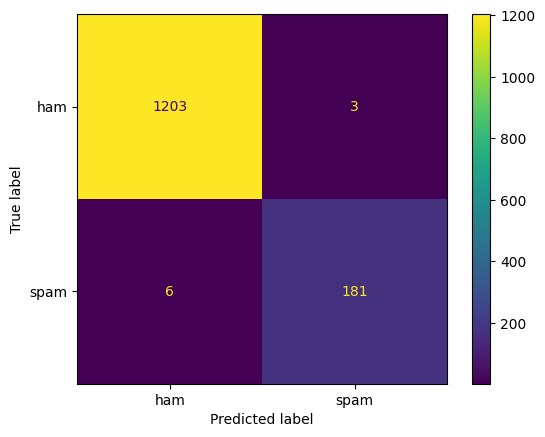

In [168]:
conf_mat = confusion_matrix(df_results['Result'], df_results['TensorFlow'], labels=["ham", "spam"])
ConfusionMatrixDisplay(conf_mat, display_labels = ["ham", "spam"]).plot()

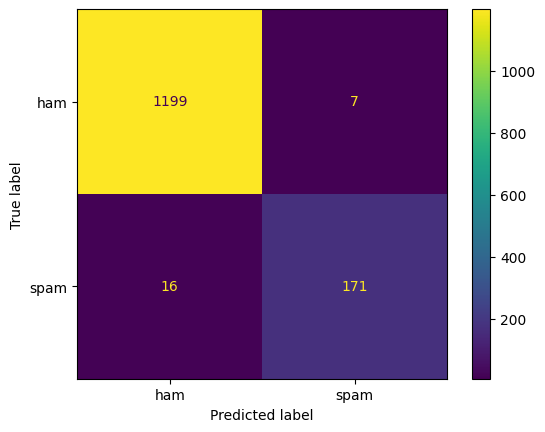

In [220]:
# conf_mat = confusion_matrix(df_results['Result'], df_results['TensorFlow'], labels=["ham", "spam"])
ConfusionMatrixDisplay(confusion_matrix(df_results['Result'], df_results['TinyBert'], labels=["ham", "spam"])
                       , display_labels = ["ham", "spam"]).plot()

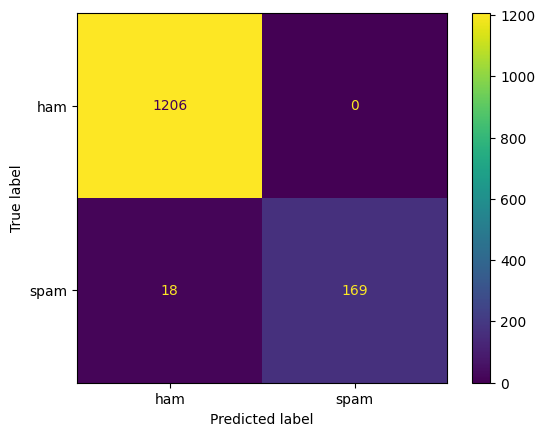

In [221]:
ConfusionMatrixDisplay(confusion_matrix(df_results['Result'], df_results['MLP'], labels=["ham", "spam"])
                       , display_labels = ["ham", "spam"]).plot()